# Bài tập cuối
*Bài tập này gồm các file: `compression.py`, `k_nearest_neighbor.py` và `features.py`

Nội dung:
- Nén ảnh dùng phương pháp SVD
- Nhận dạng ảnh dùng phương pháp k-NN.
- Cải tiến nhận dạng với PCA + k-NN và LDA + k-NN

In [1]:
# Setup
from time import time
from collections import defaultdict

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from skimage import io

%matplotlib inline
plt.rcParams['figure.figsize'] = (15.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print ("Họ tên SV1: (Mã SV: )")
print ("Họ tên SV2: (Mã SV: )")
# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

Họ tên SV1: (Mã SV: )
Họ tên SV2: (Mã SV: )


## Phần 1 - Nén ảnh (15 điểm)

Nén ảnh là giảm kích thước bộ nhớ dùng lưu trữ ảnh.
Một trong các phương pháp nén ảnh mất thông tin là sử dụng Tác giá trị kỳ dị (Singular Value Decomposition - SVD) lên ảnh và giữ lại n giá trị kỳ dị (singular values) đầu tiên (lớn nhất).

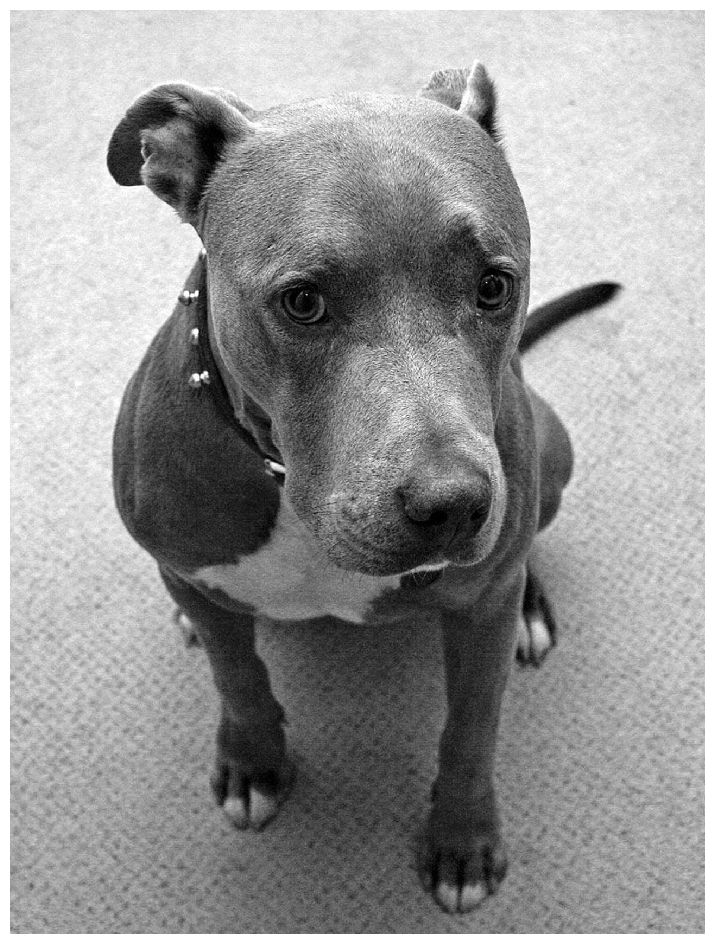

In [2]:
image = io.imread('pitbull.jpg', as_gray=True)
plt.imshow(image)
plt.axis('off')
plt.show()

Ta sẽ dùng SVD để nén ảnh trên (hình con chó).
Trước hết, tính SVD của ảnh (xem lại lý thuyết) và giữ lại `n` singular values lớn nhất cùng với các singular vectors tương ứng để dựng lại ảnh.

Hãy cài đặt hàm `compress_image` trong file `compression.py`.

In [3]:
from compression import compress_image

compressed_image, compressed_size = compress_image(image, 100)
compression_ratio = compressed_size / image.size
print('Original image shape:', image.shape)
print('Compressed size: %d' % compressed_size)
print('Compression ratio: %.3f' % compression_ratio)

assert compressed_size == 298500

Original image shape: (1704, 1280)
Compressed size: 298500
Compression ratio: 0.137


Data size (original): 2181120
Data size (compressed): 29850
Compression ratio: 0.013686


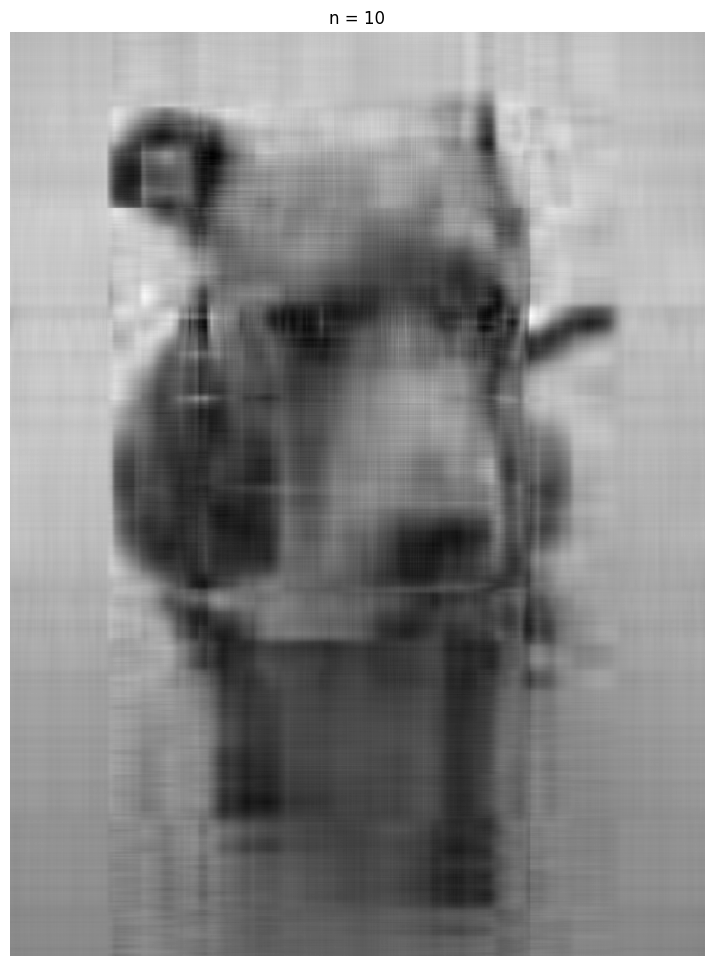

Data size (original): 2181120
Data size (compressed): 149250
Compression ratio: 0.068428


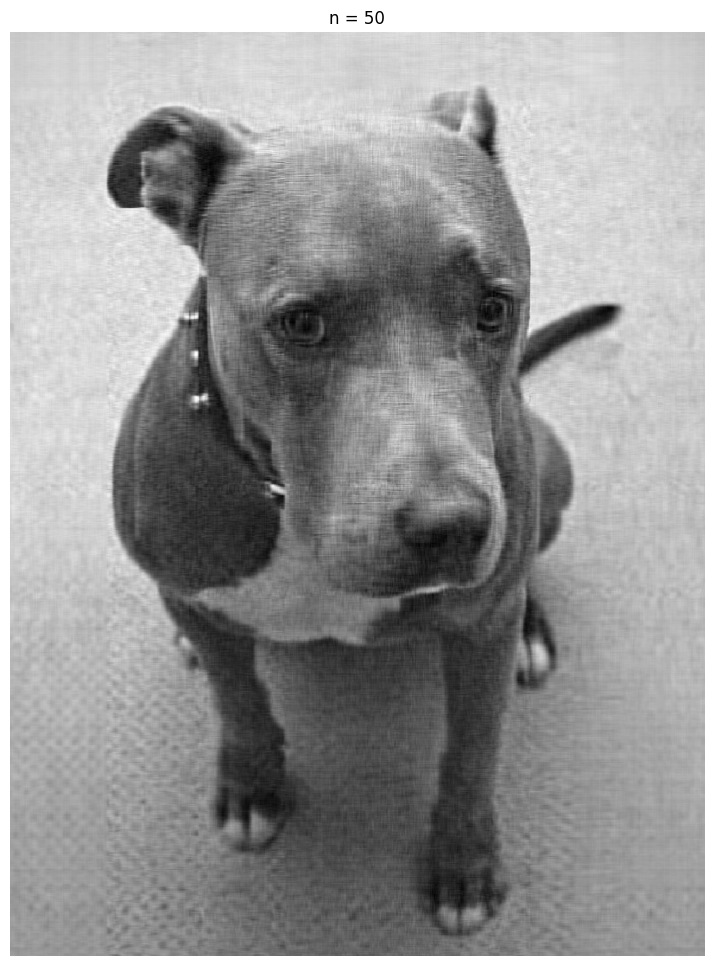

Data size (original): 2181120
Data size (compressed): 298500
Compression ratio: 0.136856


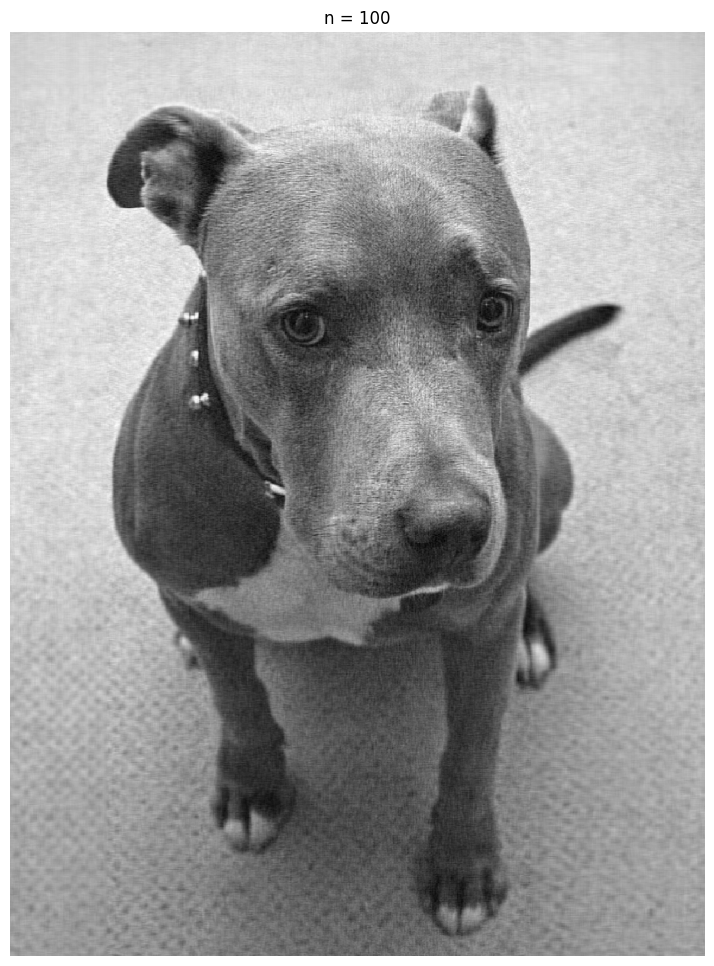

In [4]:
# Number of singular values to keep
n_values = [10, 50, 100]

for n in n_values:
    # Compress the image using `n` singular values
    compressed_image, compressed_size = compress_image(image, n)
    
    compression_ratio = compressed_size / image.size

    print("Data size (original): %d" % (image.size))
    print("Data size (compressed): %d" % compressed_size)
    print("Compression ratio: %f" % (compression_ratio))



    plt.imshow(compressed_image, cmap='gray')
    title = "n = %s" % n
    plt.title(title)
    plt.axis('off')
    plt.show()

## Tập dữ liệu mặt người

Ta sẽ sử dụng tập dữ liệu mặt người (của các người nổi tiếng). Tập dữ liệu ảnh được lưu ở thư mục `faces` với cấu trúc như sau:


    faces/
        train/
            angelina jolie/
            anne hathaway/
            ...
        test/
            angelina jolie/
            anne hathaway/
            ...

Tập dữ liệu gồm có 16 lớp. Mỗi lớp có 50 ảnh dùng để huấn luyện (training images) và 10 ảnh dùng để kiểm tra (testing images).

Tất cả các ảnh đều được chỉnh kích thước về $64 \times 64$.

In [ ]:
from utils import load_dataset

X_train, y_train, classes_train = load_dataset('faces', train=True, as_grey=True)
X_test, y_test, classes_test = load_dataset('faces', train=False, as_grey=True)

assert classes_train == classes_test
classes = classes_train

print('Class names:', classes)
print('Training data shape:', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape:', X_test.shape)
print('Test labels shape: ', y_test.shape)

TypeError: read() got an unexpected keyword argument 'as_grey'

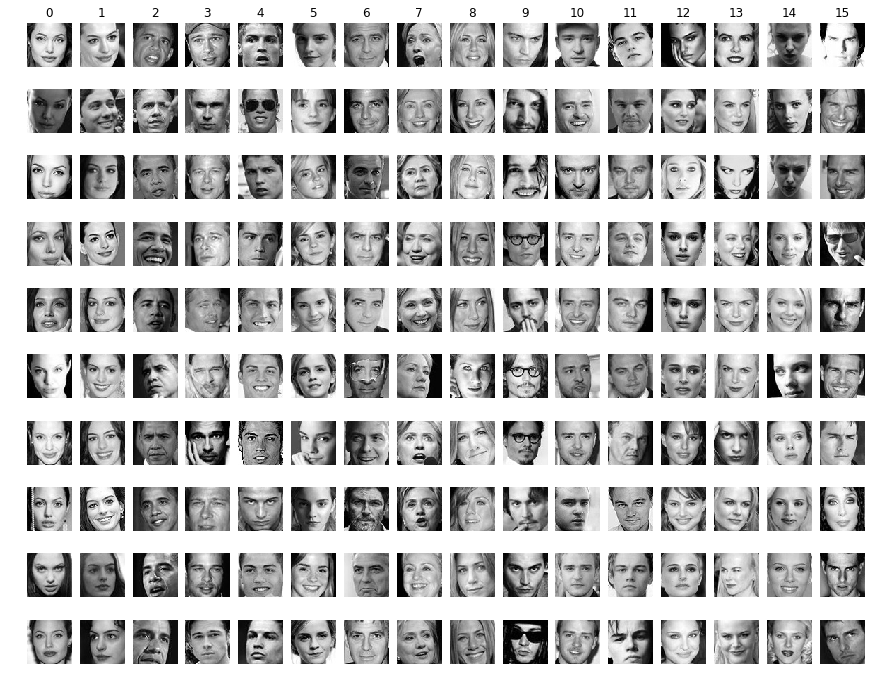

In [ ]:
# Hiển thị một số ảnh trong tập dữ liệu để xem thử.
# Ta sẽ chọn ngẫu nhiên 10 ảnh cho mỗi lớp để hiển thị.
num_classes = len(classes)
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx])
        plt.axis('off')
        if i == 0:
            plt.title(y)
plt.show()

In [ ]:
# Trích đặc trưng cho ảnh bằng cách trải dài ảnh (flatten) thành một vector.
# Như thế mỗi ảnh sẽ được biểu diễn bằng một vector đặc trưng 64 x 64 = 4096 chiều.
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print("Training data shape:", X_train.shape)
print("Test data shape:", X_test.shape)

Training data shape: (800, 4096)
Test data shape: (160, 4096)


---
## Phần 2 - k-Nearest Neighbor (30 điểm)

Giờ đây ta thử sử dụng phương pháp k-NN trên các **đặc trưng thô của ảnh** (giá trị mức xám của tất cả các pixel) để phân lớp các ảnh kiểm tra trong thư mục `test`. Ta sẽ cải tiến k-NN sau.

Các bước thực hiện:
1. Tính khoảng cách L2 (khoảng cách Euclide) từ mỗi ảnh kiểm tra nằm trong tập X_test và mỗi ảnh nằm huấn luyện nằm trong X_train bằng hàm `compute_distances`.
2. Sử dụng hàm `split_folds` chia tập dữ liệu X_train thành 5 tập con (5 folds) để tìm k tốt nhất bằng phương pháp kiểm tra chéo (cross-validation).
3. Với tập con, và mỗi giá trị `k`, ta dự báo nhãn/lớp (classes/labels) của dữ liệu kiểm tra và tính độ chính xác nhận dạng (accuracy).
4. Sử dụng giá trị `k` tốt nhất tìm được bằng phương pháp cross-validation, ta phân lớp lại tập kiểm tra X_test để tính lại độ chính xác nhận dạng.

In [ ]:
from k_nearest_neighbor import compute_distances

# Bước 1: Tính khoảng cách từ mỗi ảnh trong X_test đến mỗi ảnh trong X_train.
dists = compute_distances(X_test, X_train)
assert dists.shape == (160, 800)
print("dists shape:", dists.shape)

dists shape: (160, 800)


In [ ]:
from k_nearest_neighbor import predict_labels

# Sử dụng k = 1 (chỉ chọn 1 láng giềng gần nhất để phân lớp)
y_test_pred = predict_labels(dists, y_train, k=1)

# Tính và in tỉ lệ nhận dạng chính xác. Ta sẽ thấy rằng độ chính xác rất thấp (chỉ có khoảng 6%!)
num_test = y_test.shape[0]
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

Got 38 / 160 correct => accuracy: 0.237500


### Tìm k bằng phương pháp kiểm tra chéo (Cross-Validation)

Ta không biết giá trị tốt nhất cho `k` là bao nhiêu. Vì thế, ta phải tìm `k` bằng phương pháp kiểm tra chéo.  

Ta **không được phép** sử dụng tập dữ liệu kiểm tra (test set) để chọn giá trị `k`, vì nếu làm như thế ta đã `ăn gian` kết quả (biết đáp án trước khi thi).

Bạn chỉ được sử dụng tập huấn luyện để tìm giá trị `k` tốt nhất.

Phương pháp Cross-validation sẽ được thực hiện như sau: Ta sẽ chia tập huấn luyện thành một số tập con (ở đây ta chọn 5).  
Với mỗi lần kiểm tra chéo, ta có:
- 80% dữ liệu làm tập huấn luyện
- 20% dữ liệu làm dữ liệu kiểm tra chéo

Ta sẽ tính độ chính xác nhận dạng cho mỗi tập dữ liệu và tính độ chính xác trung bình sau 5 lần kiểm tra chéo để chọn ra giá trị `k` cho độ chính xác trung bình cao nhất.

In [ ]:
from k_nearest_neighbor import split_folds

# Bước S2: chia tập dữ liệu huấn luyện thành 5 phần và thực hiện kiểm tra chéo (cross-validation).
num_folds = 5

X_trains, y_trains, X_vals, y_vals = split_folds(X_train, y_train, num_folds)

assert X_trains.shape == (5, 640, 4096)
assert y_trains.shape == (5, 640)
assert X_vals.shape == (5, 160, 4096)
assert y_vals.shape == (5, 160)

In [ ]:
# Bước 3: Tính độ chính xác trung bình cho mỗi giá trị `k`

# Tạo 1 danh sách các giá trị cho k
k_choices = list(range(5, 101, 5))

# Dictionnary mapping k values to accuracies
# Với mỗi giá trị k, ta cần phải tính độ chính xác nhận dạng `num_folds` (5) lần.
# Ví dụ k_to_accuracies[1] sẽ có các giá trị [0.22, 0.23, 0.19, 0.25, 0.20] với 5 lần.
k_to_accuracies = {}

for k in k_choices:
    print("Running for k=%d" % k)
    accuracies = []
    for i in range(num_folds):
        # Dự báo/nhận dạng
        fold_dists = compute_distances(X_vals[i], X_trains[i])
        y_pred = predict_labels(fold_dists, y_trains[i], k)

        # Tính và in tỉ lệ nhận dạng đúng
        num_correct = np.sum(y_pred == y_vals[i])
        accuracy = float(num_correct) / len(y_vals[i])
        accuracies.append(accuracy)
        
    k_to_accuracies[k] = accuracies
    print(k_to_accuracies[k])


Running for k=5
[0.225, 0.25625, 0.1875, 0.225, 0.23125]
Running for k=10
[0.2125, 0.2375, 0.175, 0.24375, 0.19375]
Running for k=15
[0.21875, 0.24375, 0.1625, 0.20625, 0.24375]
Running for k=20
[0.2375, 0.25, 0.1625, 0.225, 0.23125]
Running for k=25
[0.2125, 0.23125, 0.1875, 0.2125, 0.25]
Running for k=30
[0.21875, 0.2375, 0.19375, 0.20625, 0.2875]
Running for k=35
[0.19375, 0.19375, 0.19375, 0.18125, 0.26875]
Running for k=40
[0.19375, 0.20625, 0.19375, 0.19375, 0.2625]
Running for k=45
[0.2125, 0.21875, 0.1875, 0.225, 0.2625]
Running for k=50
[0.225, 0.2125, 0.19375, 0.225, 0.25]
Running for k=55
[0.21875, 0.2125, 0.16875, 0.225, 0.25625]
Running for k=60
[0.2, 0.21875, 0.1875, 0.1875, 0.2625]
Running for k=65
[0.1875, 0.23125, 0.18125, 0.19375, 0.24375]
Running for k=70
[0.1875, 0.225, 0.1875, 0.18125, 0.2375]
Running for k=75
[0.2125, 0.225, 0.19375, 0.18125, 0.2]
Running for k=80
[0.19375, 0.2125, 0.19375, 0.16875, 0.20625]
Running for k=85
[0.21875, 0.1875, 0.19375, 0.15625, 0.2

[0.225   0.2125  0.215   0.22125 0.21875 0.22875 0.20625 0.21    0.22125
 0.22125 0.21625 0.21125 0.2075  0.20375 0.2025  0.195   0.19625 0.18375
 0.18125 0.18375]
[ 30   5  45  20  50  25  55  15  10  60  40  65  35  70  75  85  80  90
 100  95]
[0.02200852 0.02592055 0.03       0.03051639 0.0209165  0.0327395
 0.03162278 0.0266927  0.0242384  0.01837117 0.02811805 0.02806243
 0.02512469 0.02291288 0.01510381 0.015      0.0245586  0.02038688
 0.02822897 0.03077133]
[ 80  75  50  90  25   5  70  45  85  65  10  40  60  55  95  15  20 100
  35  30]


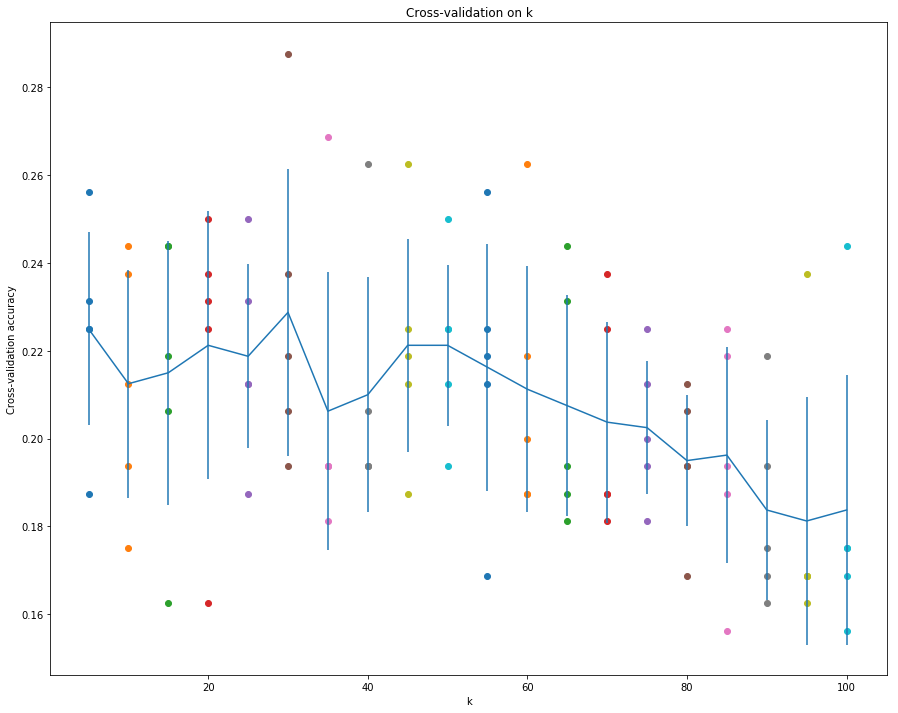

In [ ]:
# Vẽ đồ thị để xem kết quả
for k in k_choices:
    accuracies = k_to_accuracies[k]
    plt.scatter([k] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(k_to_accuracies.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(k_to_accuracies.items())])
print(accuracies_mean)
print((np.argsort(accuracies_mean)+1)[::-1]*5)
print(accuracies_std)
print((np.argsort(accuracies_std)+1)*5)

plt.errorbar(k_choices, accuracies_mean, yerr=accuracies_std)
plt.title('Cross-validation on k')
plt.xlabel('k')
plt.ylabel('Cross-validation accuracy')
plt.show()

In [ ]:
# Dự trên kết quả kiểm tra chéo ở trên, chọn giá trị k tốt nhất,   
# Huấn luyện lại tập dữ liệu huấn luyện
# (phương pháp k-NN không cần huấn luyện nhưng ta phải giữ lại giá trị k tốt nhất để phân lớp) 
# Bạn sẽ thấy độ chính xác tăng lên so với k = 1: 26%.

best_k = None
# YOUR CODE HERE
# Choose the best k based on the cross validation above
best_k = (np.argsort(accuracies_mean)[-1]+1)*5
# Chọn k có trung bình accuracy cao nhất
# END YOUR CODE

y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('For k = %d, got %d / %d correct => accuracy: %f' % (best_k, num_correct, num_test, accuracy))

For k = 30, got 42 / 160 correct => accuracy: 0.262500


---
## Phần 3: PCA (30 điểm)

Phân tích thành phần chính (Principal Component Analysis - PCA) là một kỹ thuật biến đổi tuyến tính đơn giản, phổ biến và hữu dụng được sử dụng trong rất nhiều ứng dụng như: dự báo thị trường chứng khoán, phân tích dữ liệu gen, v.v. 

Trong phần này, ta sẽ tìm hiểu cặn kẽ về cách tính PCA và cách sử dụng nó.

### Giới thiệu
The sheer size of data in the modern age is not only a challenge for computer hardware but also a main bottleneck for the performance of many machine learning algorithms.

Mục đích chính của PCA là phát hiện ra các dạng/mẫu (patterns) của dữ liệu; PCA hướng đến việc phát hiện mối tương quan giữa các biến/thuộc tính/cột của dữ liệu; 
Nếu 2 hay nhiều cột dữ liệu tương quan mạnh với nhau (ví dụ: X1 và X2 cùng tăng, cùng giảm hoặc X1 tăng thì X2 giảm), ta có thể gom nhiều cột thành một nhằm giảm chiều dữ liệu. Nói một cách đơn giản, PCA tìm những trục có phương sai lớn nhất và chiếu dữ liệu nhiều chiều lên không gian con ít chiều hơn và cố gắng giữ càng nhiều thông tin gốc càng tốt.

### Các bước chính để thực hiện PCA
- Chuẩn hoá/quy tâm dữ liệu: đưa tâm của của dữ liệu $\mathbf{X}$ về gốc toạ độ (tính giá trị trung bình và lấy từng phần tử trừ giá trị trung bình), ta thu được dữ liệu chuẩn hoá $\mathbf{X_centered}$: .
- Tính ma trận phương sai - hiệp phương sai và tìm giá trị riêng (Eigenvalues) và vector riêng (Eigenvectors) của nó hoặc tính Singular Vector Decomposition (SVD) trên ma trận dữ liệu đã chuẩn hoá $\mathbf{X_centered}$.
- Sắp xếp các giá trị riêng (eigenvalues) giảm dần và chọn $k$ vector riêng (eigenvectors) tương ứng với $k$ giá trị riêng lớn nhất với $k$ là số chiều cần giữ lại ($k \leq d$). Hàm `numpy.argsort` có thể sẽ có ích cho bạn.
- Ghép $k$ vector riêng lại thành ma trận chiếu (projection matrix) $\mathbf{U}$. Trong file `features.py`, ta đặt tên ma trận này là `U_pca`.
- Biến đổi/chiếu (Transform/Project) dữ liệu gốc $\mathbf{X}$ dùng ma trận biến đổi $\mathbf{U}$ để thu được dữ liệu mới $\mathbf{Z}$ có $k$ chiều.

In [ ]:
from features import PCA

pca = PCA()

### 3.1 - Tách giá trị riêng (Eigendecomposition)
Vector riêng và giá trị riêng của ma trận phương sai biểu diễn thành phần cốt lõi của PCA: các vector riêng (còn gọi là các thành phần chính - principal components) xác định hướng của các trục toạ độ của không gian mới, các giá trị riêng xác định độ lớn của các thành phần chính. Nói cách khác, giá riêng giải thích phương sai của dữ liệu theo các trục mới.

Ma trận phương sai (chú ý: $\mathbf{X}$ đã được quy tâm)
$$
\Sigma = X^T X 
$$


Hãy cài đặt hàm **`_eigen_decomp`** trong `pca.py`.

In [ ]:
# Tách giá trị riêng trên ma trận phương sai của dữ liệu huấn luyện.
e_vecs, e_vals = pca._eigen_decomp(X_train - X_train.mean(axis=0))

print(e_vals.shape)
print(e_vecs.shape)

### 3.2 - Tách giá trị kỳ dị (Singular Value Decomposition - SVD)
Tính giá trị riêng và vector của ma trận phương sai rất tốn thời gian, nhất là khi số chiều của dữ liệu (ví dụ: `D = 4096`) lớn.

Để có được giá trị riêng và vector riêng giống hệt như trên ta có thể sử dụng SVD trên ma trận đã chuẩn hoá/quy tâm. Nếu thực hiện SVD trên ma trận $X$, ta sẽ thu được $U$, $S$ và $V$ sao cho:
$$
X = U S V^T
$$

- Các cột của $U$ là các vector riêng của ma trận $X X^T$
- Các cột của $V^T$ là các vector riêng của ma trận $X^T X$
- Các giá trị kỳ dị của $S$ bằng căn bậc hai của các giá trị riêng của $X^T X$ (hoặc $X X^T$)


Vì vậy, ta có thể tìm `k` vector riêng của ma trận phương sai $\Sigma = X^T X$ dùng SVD.

Hãy cài đặt hàm **`_svd`** trong file `pca.py`.

In [ ]:
# Perform SVD on directly on the training data.
u, s = pca._svd(X_train - X_train.mean(axis=0))

print(s.shape)
print(u.shape)

In [ ]:
# Kiểm tra kết quả trả về của 2 phương pháp: về lý thuyết kết quả này phải giống hệt nhau.
# Tuy nhiên, do sai số tính toán, kết quả có thể khác nhau.
# Ta có thể nhận thấy rằng các cột của `e_vecs` và của `u` sẽ giống nhau (có thể ngược dấu).
N = X_train.shape[0]
assert np.allclose((s ** 2) / (N - 1), e_vals[:len(s)])
for i in range(len(s) - 1):
    assert np.allclose(e_vecs[:, i], u[:, i]) or np.allclose(e_vecs[:, i], -u[:, i])
    # (the last eigenvector for i = len(s) - 1 is very noisy because the eigenvalue is almost 0,
    #  so imprecisions in the computation build up)

### 3.3 - Giảm chiều

$k$ thành phần chính đầu tiên của PCA giải thích gần như tất cả phương sai của dữ liệu.

Chiếu dữ liệu gốc (ảnh mặt người) lên không gian con của $k$ thành phần chính, ta có thể giảm chiều của dữ liệu mà vẫn giữ được hầu hết thông tin của dữ liệu.

Trong ví dụ bên dưới, ta sẽ thấy rằng **sử dụng 2 thành phần chính đầu tiên của PCA là không đủ** để cho phép ta nhìn thấy dạng của dữ liệu. Tất cả các ảnh dường như xuất hiện ngẫu nhiên trong mặt phẳng 2D. Vì thế, ta cần giữ lại nhiều chiều hơn 2.

In [ ]:
# Dimensionality reduction by projecting the data onto
# lower dimensional subspace spanned by k principal components

# To visualize, we will project in 2 dimensions
n_components = 2
pca.fit(X_train)
X_proj = pca.transform(X_train, n_components)

# Plot the top two principal components
for y in np.unique(y_train):
    plt.scatter(X_proj[y_train==y,0], X_proj[y_train==y,1], label=classes[y])
    
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.legend()
plt.show()

### 3.4 - Hiển thị các đặc trưng của khuôn mặt (Eigenfaces)

Các cột của ma trận chiếu `pca.U_pca` của PCA biểu diễn các vector riêng của ma trận $X^T X$.

Ta có thể hiển thị các giá trị kỳ dị (singular values) lớn nhất cũng như các vector tương ứng với chúng để hiểu được ý nghĩa của giải thuật PCA.

Nếu ta hiển thị 10 eigenfaces đầu tiên, ta có thể thấy rằng giải thuật tập trung vào sự đổ bóng của các khuôn mặt. Ví dụ, trong khuông mặt n°2 ánh sáng dường như đi từ bên trái qua.

In [ ]:
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(pca.U_pca[:, i].reshape(64, 64))
    plt.title("%.2f" % s[i])
plt.show()

In [ ]:
# Reconstruct data with principal components
n_components = 100  # Experiment with different number of components.
X_proj = pca.transform(X_train, n_components)
X_rec = pca.reconstruct(X_proj)

print(X_rec.shape)
print(classes)

# Visualize reconstructed faces
samples_per_class = 10
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow((X_rec[idx]).reshape((64, 64)))
        plt.axis('off')
        if i == 0:
            plt.title(y)
plt.show()

### Câu hỏi 1 (5 điểm) 
*Câu hỏi*: Xét một tập dữ liệu $N$ ảnh mặt người, mỗi ảnh có kích thước $(h, w)$. Như thế, ta cần $O(Nhw)$ ô nhớ để lưu toàn bộ dữ liệu. Giả sử sau khi giảm chiều trên tập dữ liệu với $p$ thành phần chính, và sử dụng các thành phần chính (các cột của vector U_pca) để phục hồi dữ liệu. Tính xem ta cần bao nhiêu ô nhớ để lưu ảnh đã giảm chiều và ma trận dùng để phục hồi lại ảnh gốc.

Nói cách khác, cần bao nhiêu ô nhớ để lưu ảnh đã nén **và** thứ dùng để giải nén.

*Trả lời:* nhấp vào đây để gõ câu trả lời.

### 3.5 - Lỗi phục hồi và phương sai được giữ lại

Ta có thể vẽ lỗi phục hồi (sự khác nhau giữa ảnh gốc và ảnh phục hồi) theo số chiều của không gian con.

Càng giữ lại nhiều thành phần chính thì lỗi phục hồi càng nhỏ.

Ta có thể thấy rằng trong đồ thị này, điểm gãy nằm vào khoảng 200 - 300. Điều này có nghĩa là con số này chính là sự dung hoà giữa lỗi phục hồi và số chiều được giảm.

In [ ]:
# Plot reconstruction errors for different k
N = X_train.shape[0]
d = X_train.shape[1]

ns = range(1, d, 100)
errors = []

for n in ns:
    X_proj = pca.transform(X_train, n)
    X_rec = pca.reconstruct(X_proj)

    # Compute reconstruction error
    error = np.mean((X_rec - X_train) ** 2)
    errors.append(error)

plt.plot(ns, errors)
plt.xlabel('Number of Components')
plt.ylabel('Reconstruction Error')
plt.show()

We can do the same process to see how much variance is captured by the projection.

Again, we see that the inflexion point is around 200 or 300 dimensions.

In [ ]:
# Plot captured variance
ns = range(1, d, 100)
var_cap = []

for n in ns:
    var_cap.append(np.sum(s[:n] ** 2)/np.sum(s ** 2))
    
plt.plot(ns, var_cap)
plt.xlabel('Number of Components')
plt.ylabel('Variance Captured')
plt.show()

### 3.6 - kNN with PCA

Thực hiện k-NN trên các đặc trưng thô (giá trị của các pixel) không cho kết quả tốt.

Tính khoảng cách giữa các ảnh trên không gian gốc không phải là cách tốt nhất để so sánh sự tương đồng giữa các ảnh.
Ví dụ, ảnh A với nền tối sẽ giống với ảnh B có nền tối mặc dù đây là 2 người khác nhau.

Sử dụng kỹ thuật PCA có thể dùng để trích các đặc trưng phù hợp và cho độ chính xác cao hơn.

Tuy nhiên, ta quan sát thấy rằng PCA không thực sự hỗ trợ nhiều lắm cho việc tìm các đặc trưng phân biệt giữa các lớp khác nhau. Vì thế, ta đạt được kết quả cũng tương đương với các đặc trưng thôi :-(

In [ ]:
num_test = X_test.shape[0]

# We computed the best k and n for you
best_k = 20
best_n = 500


# PCA
pca = PCA()
pca.fit(X_train)
X_proj = pca.transform(X_train, best_n)
X_test_proj = pca.transform(X_test, best_n)

# kNN
dists = compute_distances(X_test_proj, X_proj)
y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))

---
## Phần 4 - Fisherface: Phân tích phân biệt tuyến tính (Linear Discriminant Analysis) (25 điểm)

LDA làm phép biến đổi tuyến tính giống như PCA, nhưng với mục tiêu khác.  
Khác biệt chính là LDA sử dụng thông tin nhãn/lớp của các mẫu huấn luyện để cực đại hoá việc chia tách các lớp với nhau trong không gian biến đổi.

Vì thế, LDA không hoàn toàn là **unsupervised** vì nó cần nhãn của dữ liệu. Ngược lại PCA là **fully unsupervised**.

Tóm lại:
- PCA bảo toàn phương sai lớn nhất có thể trong không gian biến đổi.
- LDA bảo toàn sự phân biệt giữa các lớp trong không gian biến đổi. Ta muốn cực đại hoá sự chia tách các lớp với nhau và cực tiểu hoá sự khác nhau giữa các phần tử trong cùng một lớp.

In [ ]:
from features import LDA

lda = LDA()

### 4.1 - Giảm chiều dùng PCA
Để có thể áp dụng LDA, ta cần có $D < N$. Vì tập dữ liệu của chúng ta có $N = 800$ và $D = 4096$, trước hết ta phải giảm chiều xuống bằng PCA trước khi sử dụng LDA 

Đọc thêm thông tin tại: http://www.scholarpedia.org/article/Fisherfaces

In [ ]:
N = X_train.shape[0]
c = num_classes

pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train, N-c)
X_test_pca = pca.transform(X_test, N-c)

### 4.2 - Ma trận tán xạ (Scatter matrices)

Trước hết, ta tính ma trận tán xạ của từng lớp:
$$
S_W = \sum_{i=1}^c S_i
$$
trong đó $S_i = \sum_{x_k \in Y_i} (x_k - \mu_i)(x_k - \mu_i)^T$ là ma trận tán xạ của lớp $i$ (chính là ma trận phương sai - hiệp phương sai).

Sau đó, ta tính ma trận tán xạ giữa của các lớp (between-class scatter matrix):
$$
S_B = \sum_{i=1}^c N_i (\mu_i - \mu)(\mu_i - \mu)^T
$$
trong đó $N_i$ là số phần tử trong lớp $i$.

Chú ý: trong bản cài đặt, ta sử dụng công thức $(x_k - \mu_i)^T(x_k - \mu_i)$ vì dữ liệu được tổ chức theo từng hàng (trong lúc giảng dạy đã có nhắc đến phần này !!!)

In [ ]:
# Compute within-class scatter matrix
S_W = lda._within_class_scatter(X_train_pca, y_train)
print(S_W.shape)

In [ ]:
# Compute between-class scatter matrix
S_B = lda._between_class_scatter(X_train_pca, y_train)
print(S_B.shape)

### 4.3 - Giải bài toán Eigenvalue tổng quát

Hãy cài đặt hàm `fit` và `transform` của lớp `LDA`.

Chú ý: đây là bài toán LDA cho nhiều lớp, các bạn cần đọc thêm tài liệu trong slides bài giảng (phần này không dạy trên lớp).

In [ ]:
lda.fit(X_train_pca, y_train)

In [ ]:
# Dimensionality reduction by projecting the data onto
# lower dimensional subspace spanned by k principal components
n_components = 2
X_proj = lda.transform(X_train_pca, n_components)
X_test_proj = lda.transform(X_test_pca, n_components)

# Plot the top two principal components on the training set
for y in np.unique(y_train):
    plt.scatter(X_proj[y_train==y, 0], X_proj[y_train==y, 1], label=classes[y])
    
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.legend()
plt.title("Training set")
plt.show()

# Plot the top two principal components on the test set
for y in np.unique(y_test):
    plt.scatter(X_test_proj[y_test==y, 0], X_test_proj[y_test==y,1], label=classes[y])
    
plt.xlabel('1st component')
plt.ylabel('2nd component')
plt.legend()
plt.title("Test set")
plt.show()

### 4.4 - kNN với LDA

Nhờ vào thông tin về nhãn/lớp, LDA chiếu dữ liệu vào không gian phân biệt làm cho các lớp rời xa nhau. 
Điều này giúp cho k-NN rất nhiều.

Tuy nhiên, như bạn thấy ở phần 4.3, dữ liệu huấn luyện sau khi chiếu lên không gian rút gọn khá rời nhau, nhưng dữ liệu kiểm tra thì không rời nhau lắm như dữ liệu huấn luyện (có vẻ việc huấn luyện bị học vẹt - overfitting?).


Thực hiện kiểm tra chép (bạn có thể điều chỉnh `k_choices` và `n_choices` để tìm giá trị tốt nhất). Sử dụng giá trị tốt nhất để kiểm tra lại độ chính xác phân lớp trên tập kiểm tra.

In [ ]:
num_folds = 5

X_trains, y_trains, X_vals, y_vals = split_folds(X_train, y_train, num_folds)

k_choices = [1, 5, 10, 20]
n_choices = [5, 10, 20, 50, 100, 200, 500]
pass


# n_k_to_accuracies[(n, k)] should be a list of length num_folds giving the different
# accuracy values that we found when using that value of n and k.
n_k_to_accuracies = defaultdict(list)

for i in range(num_folds):
    # Fit PCA
    pca = PCA()
    pca.fit(X_trains[i])
    
    N = len(X_trains[i])
    X_train_pca = pca.transform(X_trains[i], N-c)
    X_val_pca = pca.transform(X_vals[i], N-c)
    
    # Fit LDA
    lda = LDA()
    lda.fit(X_train_pca, y_trains[i])
    
    for n in n_choices:
        X_train_proj = lda.transform(X_train_pca, n)
        X_val_proj = lda.transform(X_val_pca, n)

        dists = compute_distances(X_val_proj, X_train_proj)
            
        for k in k_choices:
            y_pred = predict_labels(dists, y_trains[i], k=k)

            # Compute and print the fraction of correctly predicted examples
            num_correct = np.sum(y_pred == y_vals[i])
            accuracy = float(num_correct) / len(y_vals[i])
            n_k_to_accuracies[(n, k)].append(accuracy)


for n in n_choices:
    print()
    for k in k_choices:
        accuracies = n_k_to_accuracies[(n, k)]
        print("For n=%d, k=%d: average accuracy is %f" % (n, k, np.mean(accuracies)))

In [ ]:
# Based on the cross-validation results above, choose the best value for k,   
# retrain the classifier using all the training data, and test it on the test
# data. You should be able to get above 40% accuracy on the test data.

best_k = None
best_n = None
# YOUR CODE HERE
# Choose the best k based on the cross validation above
pass
# END YOUR CODE

N = len(X_train)

# Fit PCA
pca = PCA()
pca.fit(X_train)
X_train_pca = pca.transform(X_train, N-c)
X_test_pca = pca.transform(X_test, N-c)

# Fit LDA
lda = LDA()
lda.fit(X_train_pca, y_train)

# Project using LDA
X_train_proj = lda.transform(X_train_pca, best_n)
X_test_proj = lda.transform(X_test_pca, best_n)

dists = compute_distances(X_test_proj, X_train_proj)
y_test_pred = predict_labels(dists, y_train, k=best_k)

# Compute and display the accuracy
num_correct = np.sum(y_test_pred == y_test)
accuracy = float(num_correct) / num_test
print("For k=%d and n=%d" % (best_k, best_n))
print('Got %d / %d correct => accuracy: %f' % (num_correct, num_test, accuracy))